# Index ITEM Datasets
Index the Intertidal Relative Extents Model and Confidence products, producing dataset documents that match the product definition.

In [2]:
base_path = '/g/data/fk4/datacube/002/ITEM/ITEM_2_0/'
product_dict = {
    'item_v2': 'ITEM_REL',
    'item_v2_conf': 'ITEM_STD',
}

In [3]:
import netCDF4 as nc
import xarray as xr
import glob
import json
import yaml
try:
    from yaml import CSafeLoader as SafeLoader
except ImportError:
    from yaml import SafeLoader

In [4]:
from datacube.index._api import Index
from datacube.index.postgres import PostgresDb
from datacube.model import Dataset, DatasetType as Product, MetadataType
from datacube.scripts.dataset import read_documents, create_dataset, parse_match_rules_options, find_matching_product
from datacube.utils import changes, validate_document

In [5]:
class SimpleConfig():
    def __init__(self, **config):
        try:
            import os
            import pwd
            default_username = pwd.getpwuid(os.geteuid()).pw_name
        except ImportError:
            # No default on Windows
            default_username = None
            
        self._config = {
            'db_hostname': '',
            'db_database': 'datacube',
            'db_connection_timeout': 60,
            'db_username': default_username,
        }
        self._config.update(config)
        
    def __getattr__(self, name):
        return self._config.get(name, None)
    
    def __dir__(self):
        return self._config.keys()
    
    def __str__(self):
        return "SimpleConfig:{}".format(''.join('\n\t{}: {}'.format(*item) for item in self._config.items()))

    def __repr__(self):
        return self.__str__()

## Set up dev and prod indexes

In [6]:
dev_config = SimpleConfig(db_hostname='130.56.244.110', db_database='andrewcube')
dev_index = Index(PostgresDb.from_config(dev_config, application_name='reindex'))

In [7]:
prod_config = SimpleConfig(db_hostname='130.56.244.105', db_database='datacube', db_port='6432')
prod_index = Index(PostgresDb.from_config(prod_config, application_name='andrewcube'))

* Add products to index
* Read dataset docs
* Correct Dataset doc
* Create dataset object
* Add to index

## Add products to index

In [ ]:
def add_products(index, products_def_doc):
    for product_doc_pth, product_doc in read_documents(products_def_doc):
        print(product_doc['name'])
        try:
            index.products.add_document(product_doc)
        except changes.DocumentMismatchError as e:
            index.products.update_document(product_doc, allow_unsafe_updates=True)

In [104]:
products_def_doc = '/home/547/adh547/Projects/digitalearthau/digitalearthau/config/products/item.yaml'
add_products(dev_index, products_def_doc)

item_v2
Metadata Type item_v2 differs from stored (metadata.format.name: 'NetCDF CF'!='NetCDF')
item_v2_conf
Metadata Type item_v2_conf differs from stored (metadata.format.name: 'NetCDF CF'!='NetCDF')


In [105]:
def make_rules(index):
    all_product_names = [prod.name for prod in index.products.get_all()]
    rules = parse_match_rules_options(index, None, all_product_names, True)
    return rules

In [106]:
rules = make_rules(dev_index)

## Loop over every product, and every file

In [107]:
from tqdm import tqdm_notebook
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

In [108]:
import pandas as pd
import datetime
def to_isodatetime(dt_string):
    return pd.to_datetime(dt_string).isoformat()

In [109]:
def add_file(file_name, product_obj, index):
    pth, doc = next(read_documents(file_name))
    uri = pth.absolute().as_uri()

    doc['extent']['from_dt'] = datetime.datetime(1986, 1, 1, 0, 0).isoformat()
    doc['extent']['to_dt'] = datetime.datetime(2016, 10, 31, 23, 59, 59).isoformat()
    doc['extent']['key_dt'] = datetime.datetime(2016, 10, 31, 23, 59, 59).isoformat()


    doc['image']['bands'] = {key: {'layer': key, 'path': ''} for key in product_obj.measurements.keys()}

    doc.update(product_obj.metadata_doc)

    dataset = create_dataset(doc, uri, rules)

    try:
        index.datasets.add(dataset, sources_policy='skip')
    except changes.DocumentMismatchError as e:
        index.datasets.update(dataset, {tuple(): changes.allow_any})
    return file_name

In [ ]:
from functools import partial
from concurrent.futures import ProcessPoolExecutor

for product_name, product_prefix in product_dict.items():
    file_list = glob.glob(base_path + product_prefix + '*.nc')
    product_obj = prod_index.products.get_by_name(product_name)
    
    print(product_name)
    add_to_product = partial(add_file, product_obj=product_obj, index=prod_index)
    
    with ProcessPoolExecutor(max_workers=3) as executor:
        files = executor.map(add_to_product, file_list)
        for file_name in tqdm_notebook(files):
            print(file_name)
            
#     for file_name in tqdm_notebook(file_list):
#         add_to_product(file_name)
#         print(file_name)

## Query and plot data

In [12]:
%matplotlib inline

In [13]:
import datacube
dc = datacube.Datacube(index=dev_index)

In [17]:
query = dict(lat=(-20.25, -20.35), lon=(118.525, 118.575))

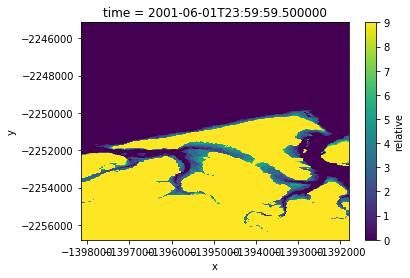

In [58]:
item_v2 = dc.load(product='item_v2', **query)
item_v2.relative.plot()

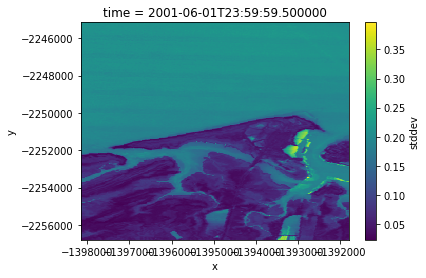

In [59]:
item_v2_conf = dc.load(product='item_v2_conf', **query)
item_v2_conf.stddev.plot()